In [1]:
# | hide
# skip
! [ -e /content ] && pip install -Uqq model_inspector nbdev
# For colab. Restart the runtime after running this cell!

In [2]:
# | default_exp inspect.tree

# Decision Tree

> Inspector functionality specific to tree models

In [3]:
# | export
from typing import Optional

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from model_inspector.colors import COLORS
from model_inspector.delegate import delegates
from model_inspector.inspect.any_model import _Inspector
from model_inspector.inspect.classifier import _BinInspector, _MultiInspector
from model_inspector.inspect.regressor import _RegInspector
import numpy as np
import pandas as pd
from sklearn.tree import plot_tree
from treeinterpreter import treeinterpreter
from typing import Union
import waterfall_chart

In [4]:
# | export
class _TreeInspector(_Inspector):
    """Decision tree model inspector"""

    @delegates(plot_tree)
    def plot_tree(self, ax: Optional[Axes] = None, **kwargs):
        """Show decision tree."""
        if ax is None:
            # these dimensions seem to work well empirically
            max_size = 50
            depth = (
                kwargs["max_depth"] + 1
                if "max_depth" in kwargs
                else self.model.get_depth()
            )
            fig_height = min(depth * 2.2, max_size)
            width = (
                2 * kwargs["max_depth"]
                if "max_depth" in kwargs
                else self.model.get_n_leaves()
            )
            fig_width = min(width * 3.5, max_size)
            _, ax = plt.subplots(figsize=(fig_width, fig_height))
        kwargs = {"filled": True, "fontsize": 12, **kwargs}
        return plot_tree(
            self.model,
            feature_names=self.X.columns,
            class_names=np.unique(self.y).astype(str),
            ax=ax,
            **kwargs,
        )[0].axes
    
    def _plot_waterfall(
        self,
        index,
        data,
        y_lab,
        bar_num_formatter,
        **kwargs,
    ):
        kwargs = {
            "sorted_value": True,
            "threshold": 0.01,
            "blue_color": COLORS["blue"],
            "green_color": COLORS["green"],
            "red_color": COLORS["orange"],
            "sorted_value": True,
            "threshold": 0.01,
            "rotation_value": 270,
        } | kwargs
        waterfall_chart.plot(
            index=index,
            data=data,
            y_lab=y_lab,
            formatting=f"{{:,{bar_num_formatter}}}",
            **kwargs
        )

In [5]:
# | export
class _TreeRegInspector(_TreeInspector, _RegInspector):
    """Decision tree regression model inspector"""

    def plot_waterfall(
        self,
        item: Union[pd.Series, np.array],
        bar_num_formatter: str = ".1f",
        tick_num_formatter: str = ".2f",
        **kwargs
    ):
        """Make a waterfall chart showing how each feature contributes
        to the prediction for the input item.

        Parameters:

        - `item`: Input item, with the same shape and value meanings as
        a single row from `self.X`
        - `bar_num_formatter`: Bar label format specifier
        - `tick_num_formatter`: Tick label format specifier

        Additional keyword arguments will be passed to
        `waterfall_chart.plot`
        """
        prediction, bias, contributions = treeinterpreter.predict(self.model, pd.DataFrame(item).T)
        index = ["int"] + [
            f"{name}: {val:{tick_num_formatter}}"
            for name, val in zip(self.X.columns, item)
        ]
        vals = np.hstack((bias, contributions[0]))
        self._plot_waterfall(
            index=index,
            data=vals,
            y_lab=self.y.name,
            bar_num_formatter=bar_num_formatter,
            **kwargs
        )
        return plt.gca()

In [6]:
# | export
class _TreeBinInspector(_TreeInspector, _BinInspector):
    """Decision tree binary classification model inspector"""

    def plot_waterfall(
        self,
        item: Union[pd.Series, np.array],
        bar_num_formatter: str = ".2f",
        tick_num_formatter: str = ".2f",
        **kwargs
    ):
        """Make a waterfall chart showing how each feature contributes
        to the prediction for the input item.

        Parameters:

        - `item`: Input item, with the same shape and value meanings as
        a single row from `self.X`
        - `bar_num_formatter`: Bar label format specifier
        - `tick_num_formatter`: Tick label format specifier

        Additional keyword arguments will be passed to
        `waterfall_chart.plot`
        """
        prediction, bias, contributions = treeinterpreter.predict(self.model, pd.DataFrame(item).T)
        index = ["int"] + [
            f"{name}: {val:{tick_num_formatter}}"
            for name, val in zip(self.X.columns, item)
        ]
        vals = np.hstack((bias[:, 1], contributions[0, :, 1]))
        self._plot_waterfall(
            index=index,
            data=vals,
            y_lab=self.y.name,
            bar_num_formatter=bar_num_formatter,
            **kwargs
        )
        return plt.gca()

In [7]:
# | export
class _TreeMultiInspector(_TreeInspector, _MultiInspector):
    """Decision tree multiclass model inspector"""

    pass

In [8]:
import sklearn.datasets
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from model_inspector import get_inspector

In [9]:
# | hide
from nbdev.showdoc import show_doc

In [10]:
show_doc(_TreeInspector.plot_tree)

---

[source](https://github.com/gsganden/model_inspector/blob/main/model_inspector/inspect/tree.py#L28){target="_blank" style="float:right; font-size:smaller"}

### _TreeInspector.plot_tree

>      _TreeInspector.plot_tree (ax:Optional[matplotlib.axes._axes.Axes]=None,
>                                max_depth=None, feature_names=None,
>                                class_names=None, label='all', filled=False,
>                                impurity=True, node_ids=False,
>                                proportion=False, rounded=False, precision=3,
>                                fontsize=None)

Show decision tree.

Remaining parameters are passed to `sklearn.tree._export.plot_tree`.

## Regression Example

In [11]:
X, y = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

In [12]:
inspector = get_inspector(DecisionTreeRegressor(max_depth=3).fit(X, y), X, y)

/Users/greg/repos/model_inspector/model_inspector/inspect/any_model.py:56: UserWarning: `model` does not have the `feature_names_in_`
                attribute, so we cannot confirm that `model`'s feature
                names match `X`'s column names. Proceed at your own
                risk!
                
  warnings.warn(


In [13]:
# | hide
from sklearn.tree import ExtraTreeClassifier, ExtraTreeRegressor

In [29]:
# | hide
TREE_MODELS = [
    DecisionTreeClassifier,
    DecisionTreeRegressor,
    ExtraTreeClassifier,
    ExtraTreeRegressor,
]

for model_class in TREE_MODELS:
    model = model_class().fit(X, y)
    for method in ["plot_tree", "plot_waterfall"]:
        assert hasattr(get_inspector(model, X, y), method)

/Users/greg/repos/model_inspector/model_inspector/inspect/any_model.py:56: UserWarning: `model` does not have the `feature_names_in_`
                attribute, so we cannot confirm that `model`'s feature
                names match `X`'s column names. Proceed at your own
                risk!
                
  warnings.warn(
/Users/greg/repos/model_inspector/model_inspector/inspect/any_model.py:56: UserWarning: `model` does not have the `feature_names_in_`
                attribute, so we cannot confirm that `model`'s feature
                names match `X`'s column names. Proceed at your own
                risk!
                
  warnings.warn(
/Users/greg/repos/model_inspector/model_inspector/inspect/any_model.py:56: UserWarning: `model` does not have the `feature_names_in_`
                attribute, so we cannot confirm that `model`'s feature
                names match `X`'s column names. Proceed at your own
                risk!
                
  warnings.warn(
/Users/greg/r

In [15]:
# | hide
from model_inspector.inspect.tree import _TreeRegInspector  # noqa: F811

In [16]:
# | hide
assert isinstance(inspector, _TreeRegInspector)

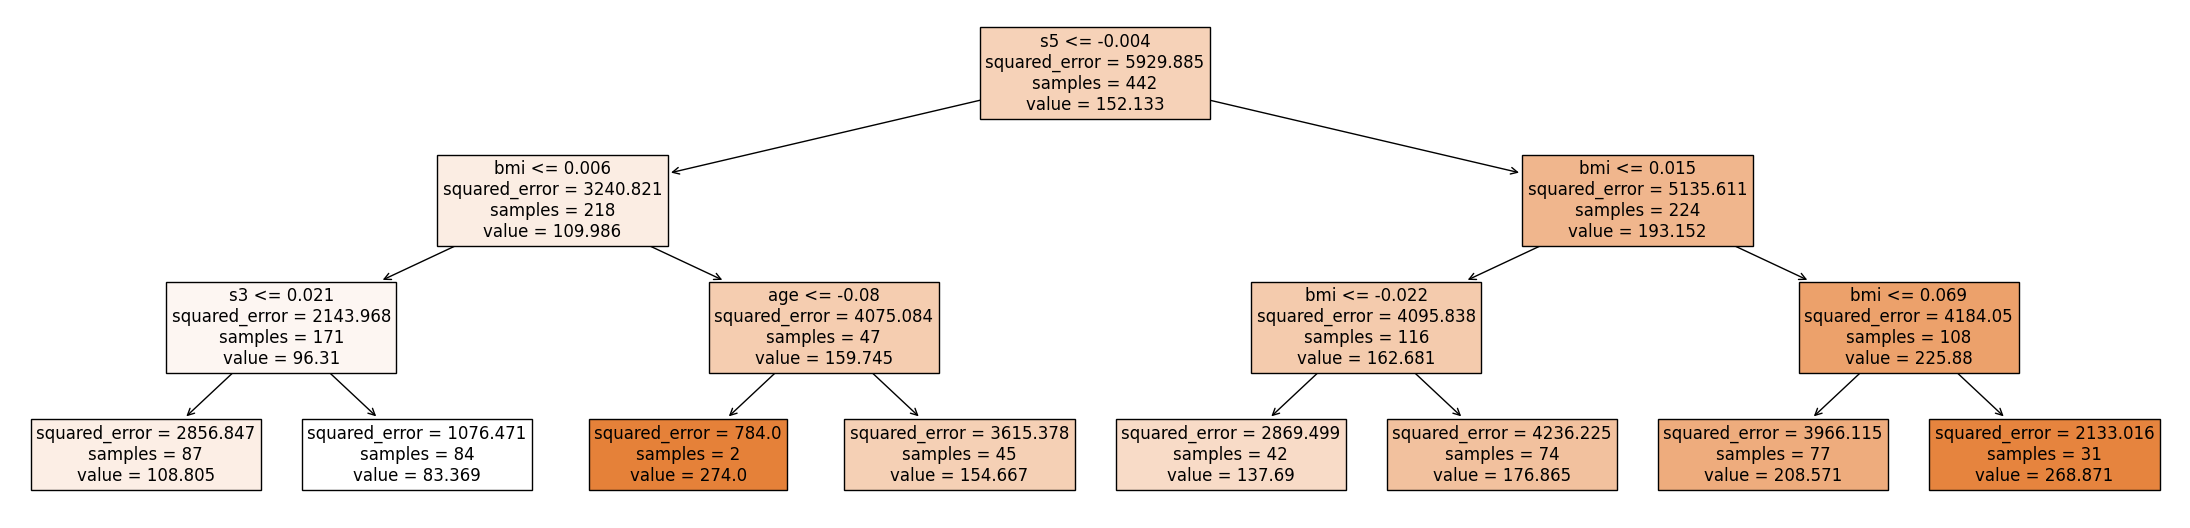

In [17]:
ax = inspector.plot_tree()

/Users/greg/.pyenv/versions/model_inspector/lib/python3.10/site-packages/waterfall_chart.py:71: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  step[1::3] = np.nan


<AxesSubplot: xlabel='\n', ylabel='target\n'>

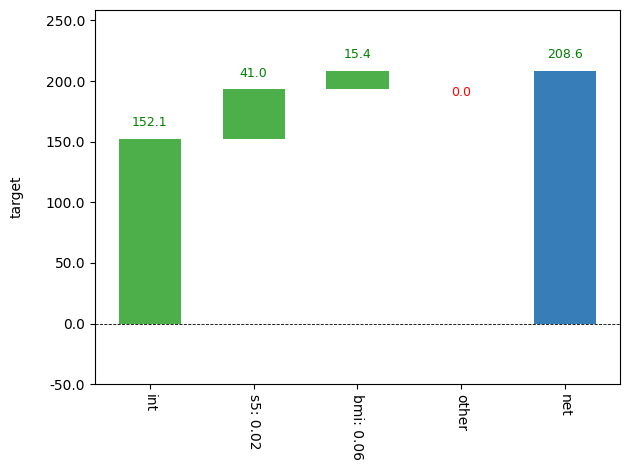

In [18]:
inspector.plot_waterfall(X.iloc[0])

## Binary Classification Example

In [19]:
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

In [20]:
inspector = get_inspector(DecisionTreeClassifier(max_depth=3).fit(X, y), X, y)

/Users/greg/repos/model_inspector/model_inspector/inspect/any_model.py:56: UserWarning: `model` does not have the `feature_names_in_`
                attribute, so we cannot confirm that `model`'s feature
                names match `X`'s column names. Proceed at your own
                risk!
                
  warnings.warn(


In [21]:
# | hide
from model_inspector.inspect.tree import _TreeBinInspector  # noqa: F811

In [22]:
# | hide
assert isinstance(inspector, _TreeBinInspector)

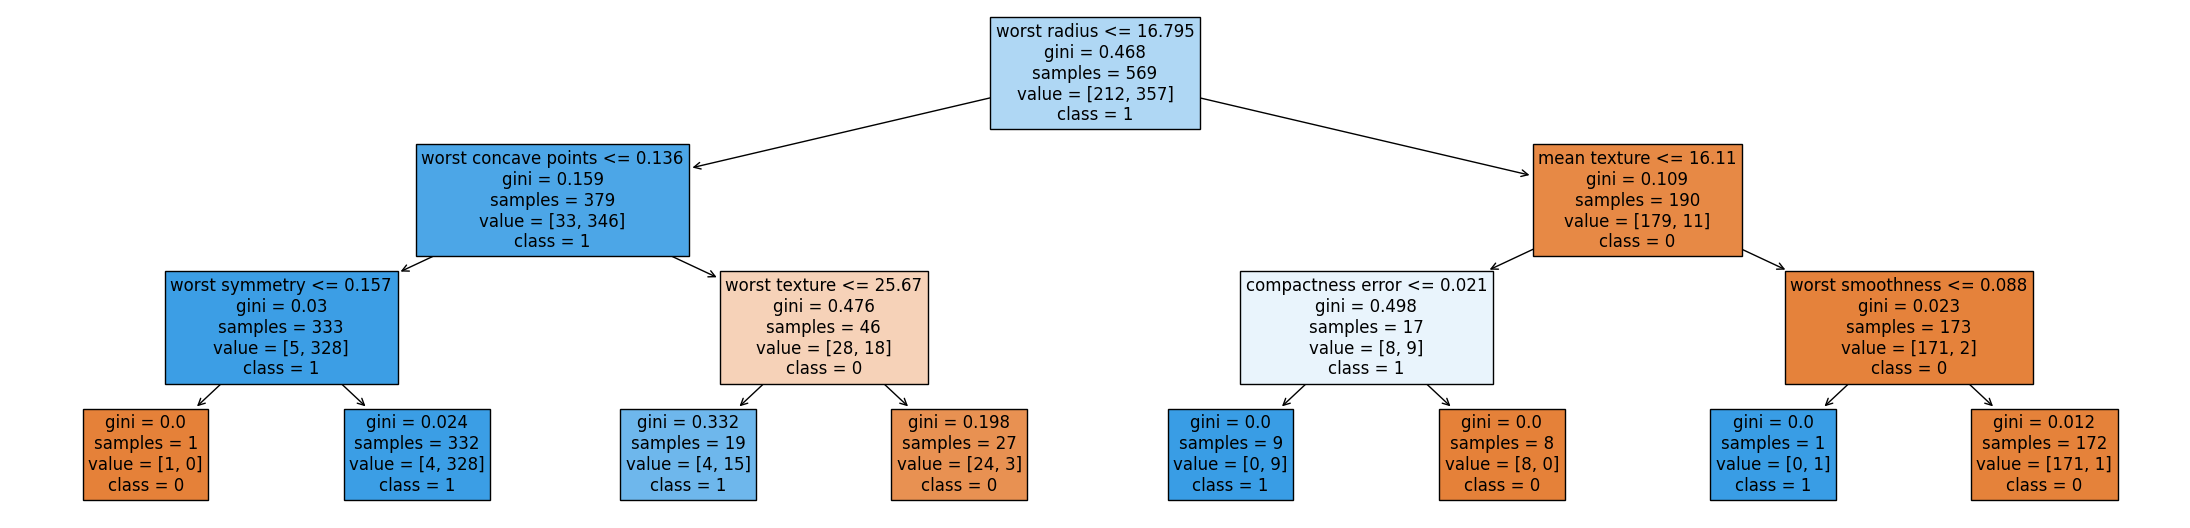

In [23]:
ax = inspector.plot_tree()

/Users/greg/.pyenv/versions/model_inspector/lib/python3.10/site-packages/waterfall_chart.py:71: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  step[1::3] = np.nan


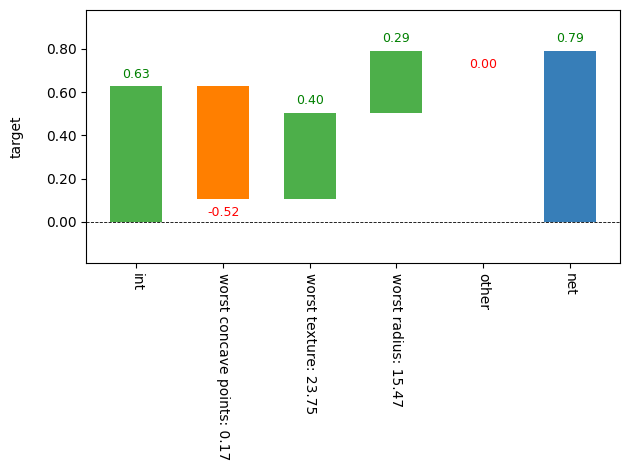

In [28]:
ax = inspector.plot_waterfall(X.iloc[5])

## Multiclass Example

In [ ]:
X, y = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)

In [ ]:
dtr = DecisionTreeClassifier(max_depth=3).fit(X, y)
inspector = get_inspector(dtr, X, y)

In [ ]:
# | hide
from model_inspector.inspect.tree import _TreeMultiInspector  # noqa: F811

In [ ]:
# | hide
assert isinstance(inspector, _TreeMultiInspector)

In [ ]:
ax = inspector.plot_tree()

In [ ]:
# | hide
import os

import matplotlib.testing.compare

In [ ]:
# | hide
"Make sure tree diagram is invariant to data ordering"
ax2 = get_inspector(
    dtr,
    X[::-1],
    y[::-1],
).plot_tree()

ax.get_figure().savefig("tmp1.png")
ax2.get_figure().savefig("tmp2.png")

assert matplotlib.testing.compare.compare_images("tmp1.png", "tmp2.png", 1e-7) is None
os.remove("tmp1.png")
os.remove("tmp2.png")

In [ ]:
# | export
_all_ = ["_TreeRegInspector", "_TreeBinInspector", "_TreeMultiInspector"]